# Machine Learning (second part): Intermediate report

*Write your name and your student ID below.*

In [60]:
# Modify these lines.
student_name = 'QIAN YI'
student_id = '20M30752'

Prepare an environment for running Python codes on Jupyter notebook. The most easiest way is to use [Google Colaboratory](https://colab.research.google.com/).

Write codes for the following four problems, and submit the notebook file (`.ipynb`) on OCW. **We do not accept a report in other formats (e.g., Word, PDF, HTML)**. You can use any deep learning library for completing this report. Write a code at the specified cell in the notebook. You can add more cells if necessary. Submit this report even if you cannot solve all problems.

These are the links to the sample codes used in the lecture:

+ [Binary classification](https://github.com/chokkan/deeplearning/blob/master/notebook/binary.ipynb)
+ [MNIST](https://github.com/chokkan/deeplearning/blob/master/notebook/mnist.ipynb)

*Please accept that your report may be shared among students who take this course.*

## 1. Multi-class classification on MNIST

Train a model on the training set of MNIST, and report the performance of the model on the test set in accuracy.

One can use the same code shown in the lecture. Write a code here and show the output.

**download the MNIST**

In [61]:
import gzip
import sys
import struct
import urllib.request
import numpy as np
import numpy.matlib 

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )

**shape the data**

In [62]:
import numpy as np
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


**visualize the data**

7


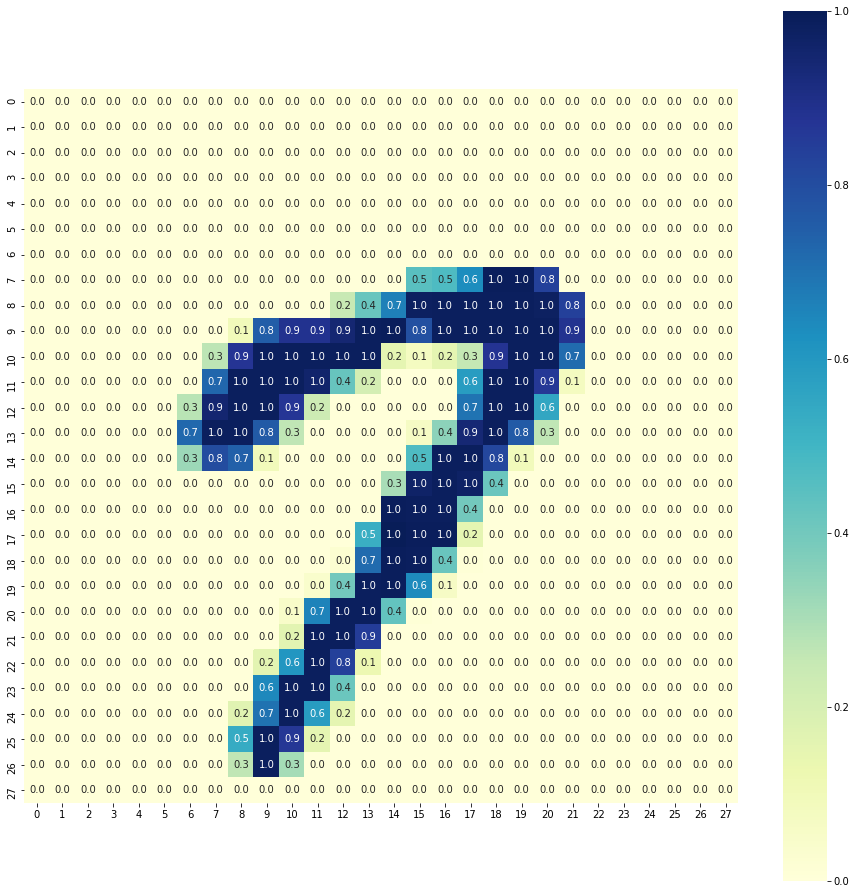

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).
i = 15

data = np.load('mnist.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

**Training model of Stochastic gradient descent for single-layer neural network(code in lecture)**

In [64]:
import numpy as np

def softmax(x):
    # We subtract the maximum value to prevent overflow and underflow problems, 
    # (result of softmax are invariant even if we add/subtract a constant)
    ex = np.exp(x - np.max(x))  # Subtract such that the maximum value is one.
    return ex / ex.sum(axis=0)

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

def label_to_onehot(Y, K):
    return np.eye(K)[Y]              # e.g., 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
    
data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])       # (60000 x 785)
Ytrain = label_to_onehot(data['train_y'], 10)   # (60000 x 10)
Xtest = image_to_vector(data['test_x'])         # (10000 x 785)
Ytest = data['test_y']                          # (10000) (not one-hot encoding)

W = np.random.randn(10, 28*28+1)                # (10 x 785)

eta = 0.001

for t in range(100):
    loss = 0.
    num_correct_train = 0
    
    # Stochastic gradient descent.
    for x, y in zip(Xtrain, Ytrain):
        y_pred = softmax(np.dot(W, x))
        loss += -np.log(y_pred[np.argmax(y)])
        W += np.outer(eta * (y - y_pred), x)    # np.outer: out[i,j] = a[i]*b[j]
        if np.argmax(y_pred) == np.argmax(y):
            num_correct_train += 1
    
    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1
            
    print('#{}: loss={:.2f}, train_accuracy={:.4f}, test_accuracy={:.4f}'.format(
        t,
        loss / len(Ytrain),
        float(num_correct_train) / len(Ytrain),
        float(num_correct_test) / len(Ytest)
    ))

#0: loss=2.75, train_accuracy=0.5861, test_accuracy=0.7700
#1: loss=1.04, train_accuracy=0.7903, test_accuracy=0.8256
#2: loss=0.83, train_accuracy=0.8268, test_accuracy=0.8474
#3: loss=0.73, train_accuracy=0.8448, test_accuracy=0.8583
#4: loss=0.66, train_accuracy=0.8552, test_accuracy=0.8674
#5: loss=0.62, train_accuracy=0.8625, test_accuracy=0.8726
#6: loss=0.58, train_accuracy=0.8676, test_accuracy=0.8777
#7: loss=0.56, train_accuracy=0.8716, test_accuracy=0.8809
#8: loss=0.54, train_accuracy=0.8758, test_accuracy=0.8837
#9: loss=0.52, train_accuracy=0.8790, test_accuracy=0.8864
#10: loss=0.50, train_accuracy=0.8820, test_accuracy=0.8882
#11: loss=0.49, train_accuracy=0.8842, test_accuracy=0.8888
#12: loss=0.47, train_accuracy=0.8867, test_accuracy=0.8911
#13: loss=0.46, train_accuracy=0.8887, test_accuracy=0.8917
#14: loss=0.45, train_accuracy=0.8906, test_accuracy=0.8936
#15: loss=0.44, train_accuracy=0.8922, test_accuracy=0.8948
#16: loss=0.44, train_accuracy=0.8938, test_accura

## 2. Confusion matrix

Show a confusion matrix of the predictions of the model on the test set. This is an example of a confusion matrix.

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusion-matrix.png?raw=1)

Write a code here and show the confusion matrix.

In [65]:
conf_matrix = np.matlib.zeros((10,10),dtype=int)
for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        conf_matrix[y,y_pred] += 1
print(conf_matrix)

[[ 953    0    3    4    0   11    5    2    2    0]
 [   0 1105    4    2    0    1    4    2   17    0]
 [   8    8  916   18    8    6   13    7   42    6]
 [   4    1   17  908    1   32    4   12   17   14]
 [   1    4    6    2  900    1   11    5    9   43]
 [  10    1    1   28    7  794   15    4   24    8]
 [  13    3   12    0   11   18  898    1    2    0]
 [   2    8   20    8    8    2    0  936    2   42]
 [   8    9    7   23    9   45   11   11  839   12]
 [   7    6    2    7   22    8    0   23   11  923]]


## 3. Top-3 easy and confusing examples

Show the top three easy and three confusing, respectively, images where the model recognized their digits with strong confidences. More specifically, let $y_n$ and $\hat{y}_n$ the true and predicted, respectively, digits of the image $x_n$. We want to find three images with high $P(\hat{y}_n | x_n)$ when $y_n = \hat{y}_n$ (for easy three examples) and $y_n \neq \hat{y}_n$ (for confusing three examples).

For each example, please show $y_n$, $P(y_n | x_n)$, $\hat{y}_n$, and $P(\hat{y}_n | x_n)$ together with the image $x_n$. This is an example of an output for an image (you need this kind of outputs for top-three easy and top-three confusing images, in other words, for six images in total).

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusing-sample.png?raw=1)

Write a code here and show the output.

In [66]:
easy_prob=[0,0,0]
conf_prob=[0,0,0]
tt_easy_prob=[0,0,0]
tt_conf_prob=[0,0,0]
easy_data=[(),(),()]
conf_data=[(),(),()]
for x, y in zip(Xtest, Ytest):
        soft=softmax(np.dot(W, x))
        prob = np.max(soft)
        tt_prob=soft[y]
        y_pred=np.argmax(np.dot(W, x))
        if y_pred==y and prob>min(easy_prob):
          i=easy_prob.index(min(easy_prob))
          easy_prob[i]=prob
          easy_data[i]=(x,y,y_pred)
          tt_easy_prob[i]=tt_prob
        if y_pred!=y and prob>min(conf_prob):
          i=conf_prob.index(min(conf_prob))
          conf_prob[i]=prob
          conf_data[i]=(x,y,y_pred)
          tt_conf_prob[i]=tt_prob


easy_matrix=[]
for tup in easy_data:
  t1=[]
  for i in range(0,28):
    t2=[]
    for j in range(0,28):
      t2.append(tup[0][i*28+j])
    t1.append(t2)
  easy_matrix.append(t1)

conf_matrix=[]
for tup in conf_data:
  t1=[]
  for i in range(0,28):
    t2=[]
    for j in range(0,28):
      t2.append(tup[0][i*28+j])
    t1.append(t2)
  conf_matrix.append(t1)
            

top3 easy examples:
=======first one======================================================================
True digit: 0(0.9999999998275251)     Prediction: 0(0.9999999998275251)


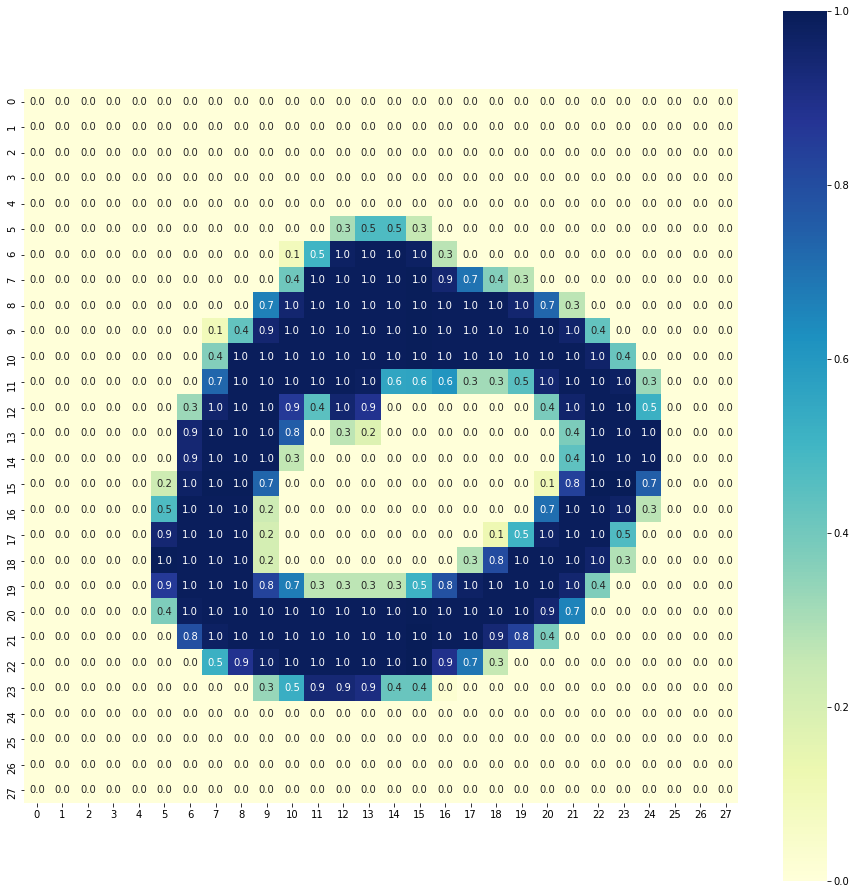

=======second one======================================================================
True digit: 0(0.9999999998090592)     Prediction: 0(0.9999999998090592)


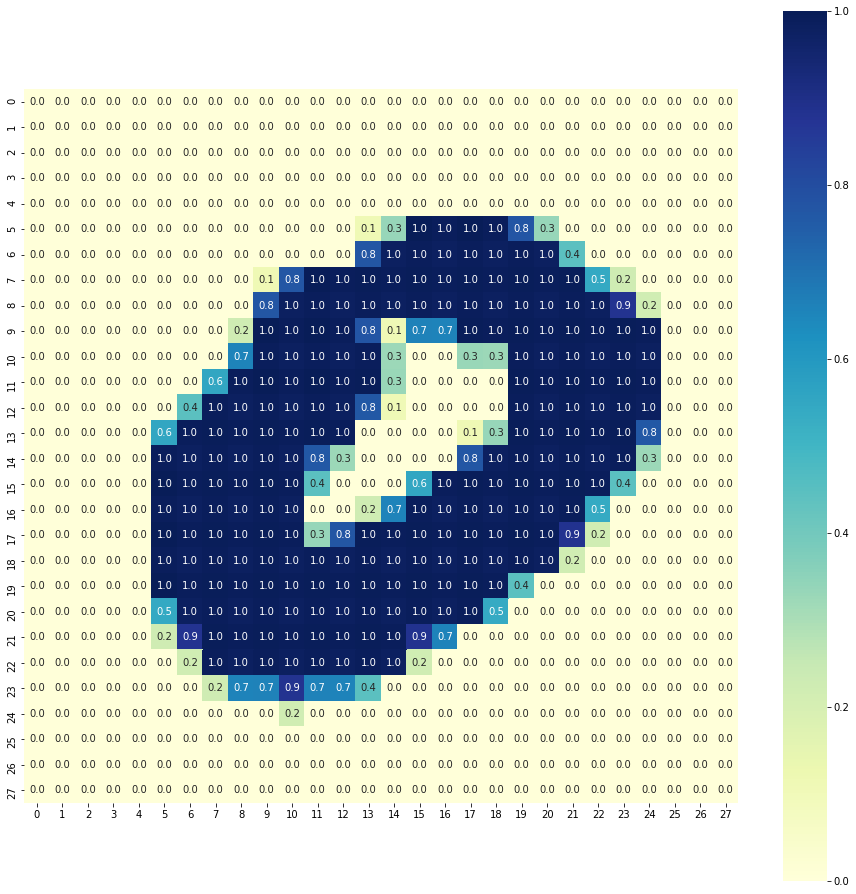

=======third one======================================================================
True digit: 0(0.9999999998305842)     Prediction: 0(0.9999999998305842)


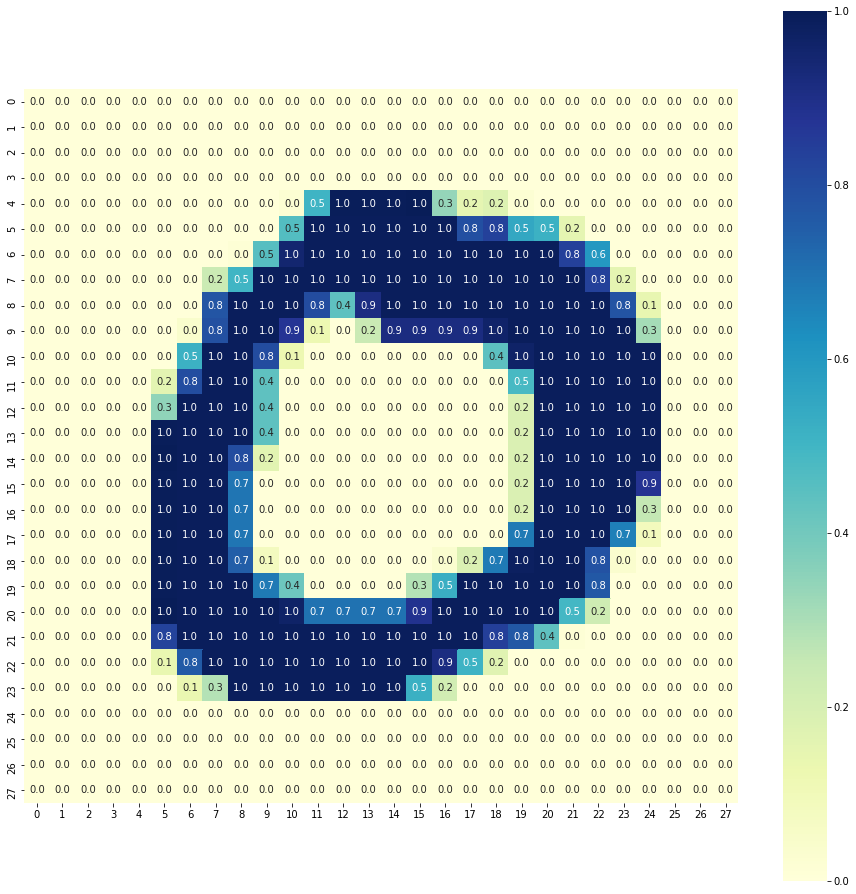

In [67]:
print("top3 easy examples:")
print("=======first one======================================================================")
print("True digit: %d(%.16f)     Prediction: %d(%.16f)"%(easy_data[0][1],tt_easy_prob[0],easy_data[0][2],easy_prob[0]))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(easy_matrix[0], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()
print("=======second one======================================================================")
print("True digit: %d(%.16f)     Prediction: %d(%.16f)"%(easy_data[1][1],tt_easy_prob[1],easy_data[1][2],easy_prob[1]))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(easy_matrix[1], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()
print("=======third one======================================================================")
print("True digit: %d(%.16f)     Prediction: %d(%.16f)"%(easy_data[2][1],tt_easy_prob[2],easy_data[2][2],easy_prob[2]))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(easy_matrix[2], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()


top3 confusing examples:
=======first one======================================================================
True digit: 5(0.0000860369311212)     Prediction: 0(0.9998267368678778)


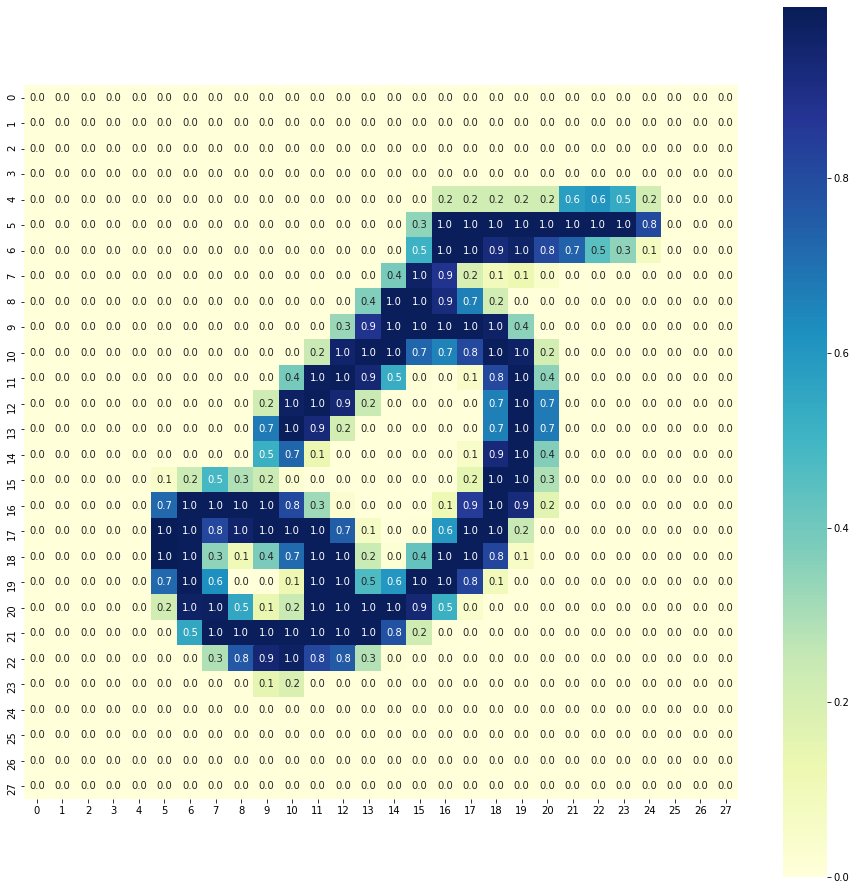

=======second one======================================================================
True digit: 8(0.0001747475238198)     Prediction: 4(0.9997221089312458)


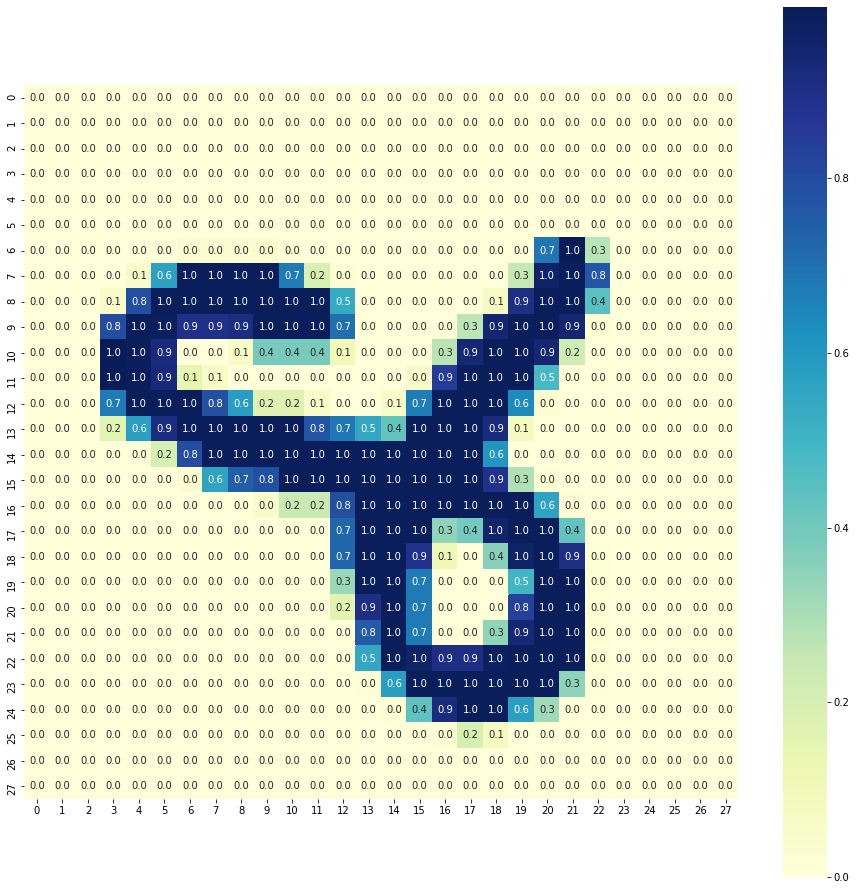

=======third one======================================================================
True digit: 8(0.0001499672437428)     Prediction: 6(0.9997535144989600)


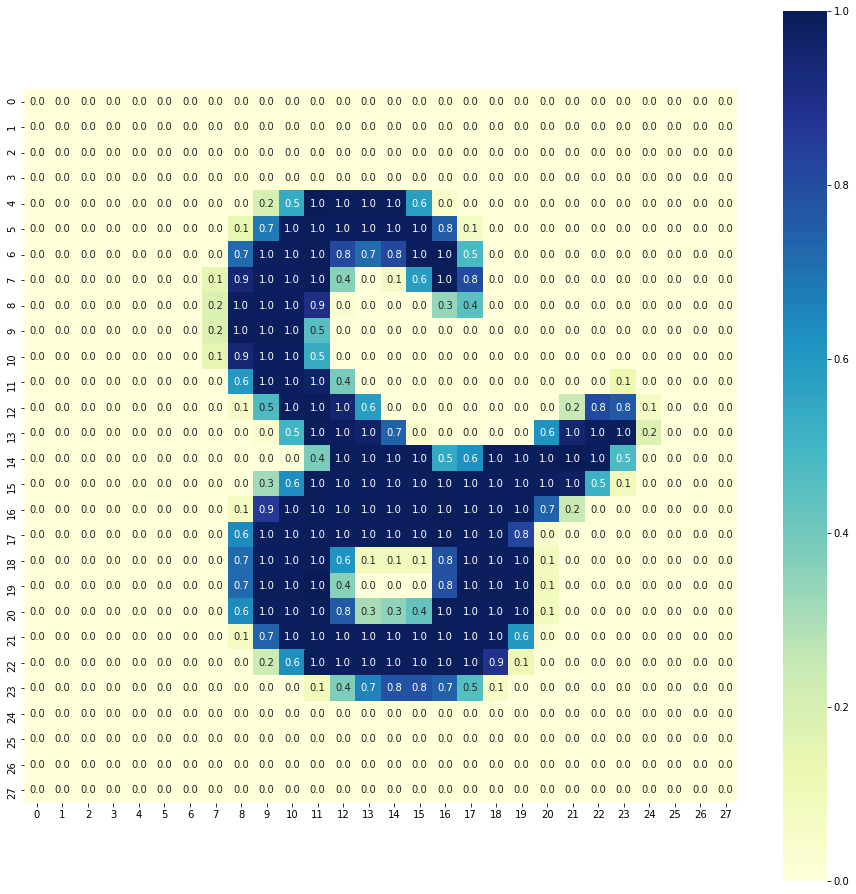

In [68]:
print("top3 confusing examples:")
print("=======first one======================================================================")
print("True digit: %d(%.16f)     Prediction: %d(%.16f)"%(conf_data[0][1],tt_conf_prob[0],conf_data[0][2],conf_prob[0]))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(conf_matrix[0], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()
print("=======second one======================================================================")
print("True digit: %d(%.16f)     Prediction: %d(%.16f)"%(conf_data[1][1],tt_conf_prob[1],conf_data[1][2],conf_prob[1]))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(conf_matrix[1], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()
print("=======third one======================================================================")
print("True digit: %d(%.16f)     Prediction: %d(%.16f)"%(conf_data[2][1],tt_conf_prob[2],conf_data[2][2],conf_prob[2]))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(conf_matrix[2], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

## 4. Recognize your handwritten digits

Prepare three image files each of which presents a digit written by you. For each image, apply the MNIST model you trained, and show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ (10-dimensional vector) for all possible digits as well as the image itself.

Please refer to [this notebook](https://colab.research.google.com/notebooks/io.ipynb) about how to upload a file to Google Colaboratory.

I choose the number 3,5,8 for test,and I find that even thouth the performance of single layer NN is good on test set,when it comes to unseen data,the performance gets bad(the pixel width of my test examples is smaller than that of MNIST test set).

### Image #1

Write the code to show the image #1 here.

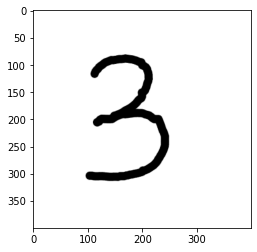

In [69]:
import matplotlib.image as mpimg
 
pic1 = mpimg.imread('3.png')
pic1.shape 
plt.imshow(pic1)  
plt.show()

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.

[3.24423921e-07 2.40982557e-02 3.21750928e-03 4.43722075e-02
 2.88762565e-02 7.99459953e-01 5.68028824e-02 5.89145083e-04
 3.30402289e-02 9.54323688e-03]
prediction is: 5


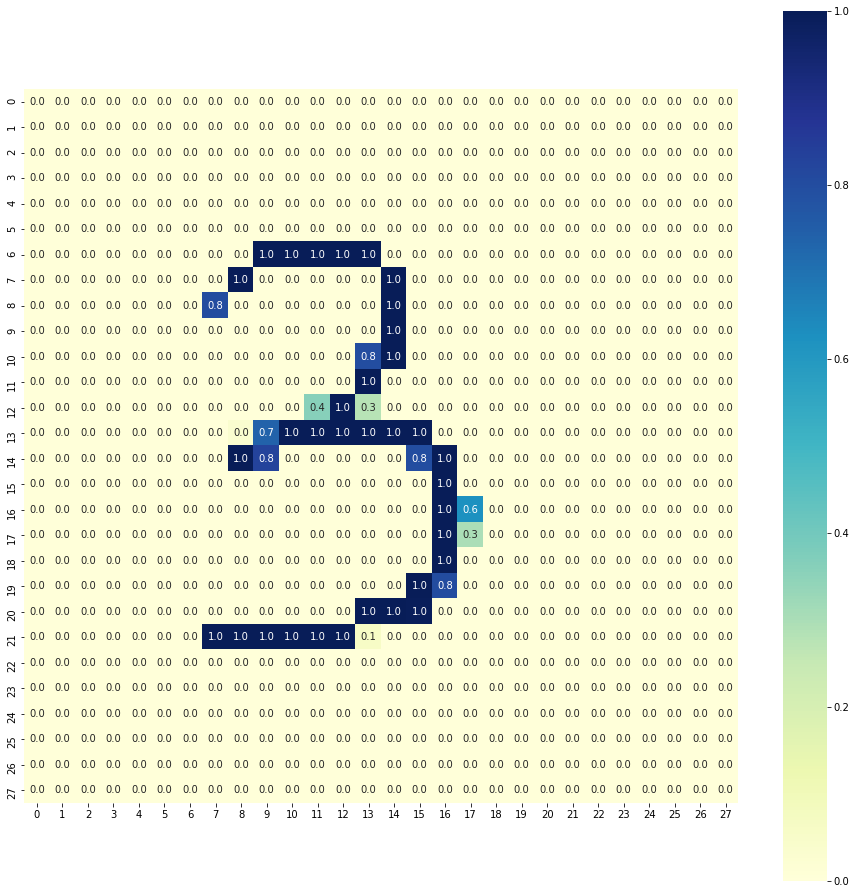

In [73]:
from PIL import Image
pic1 = Image.open('3.png')
pic1 = pic1.resize((28,28),Image.ANTIALIAS)
pic1 = pic1.convert('L')
matrix1=np.array(pic1).astype(np.float16)
matrix1=matrix1.flatten()
maxp=max(matrix1)
minp=min(matrix1)
m=float(maxp-minp)
for i in range(0,784):
  matrix1[i]=float((255-matrix1[i])/m)
  

matrix1=np.append(matrix1,1)
y_pred = np.argmax(np.dot(W, matrix1))
print(softmax(np.dot(W, matrix1)))
print("prediction is: %d"%(y_pred))
matrix1=np.delete(matrix1,-1)
matrix1=np.reshape(matrix1,(28,28))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(matrix1, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

### Image #2

Write the code to show the image #2 here.

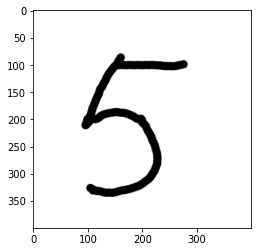

In [74]:
pic1 = mpimg.imread('5.png')
pic1.shape 
plt.imshow(pic1)  
plt.show()

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.


[1.24007029e-04 1.20062046e-07 5.96071574e-04 8.23795431e-04
 8.99729000e-06 9.95355902e-01 4.40889423e-04 1.25021927e-04
 3.86402370e-04 2.13879242e-03]
prediction is: 5


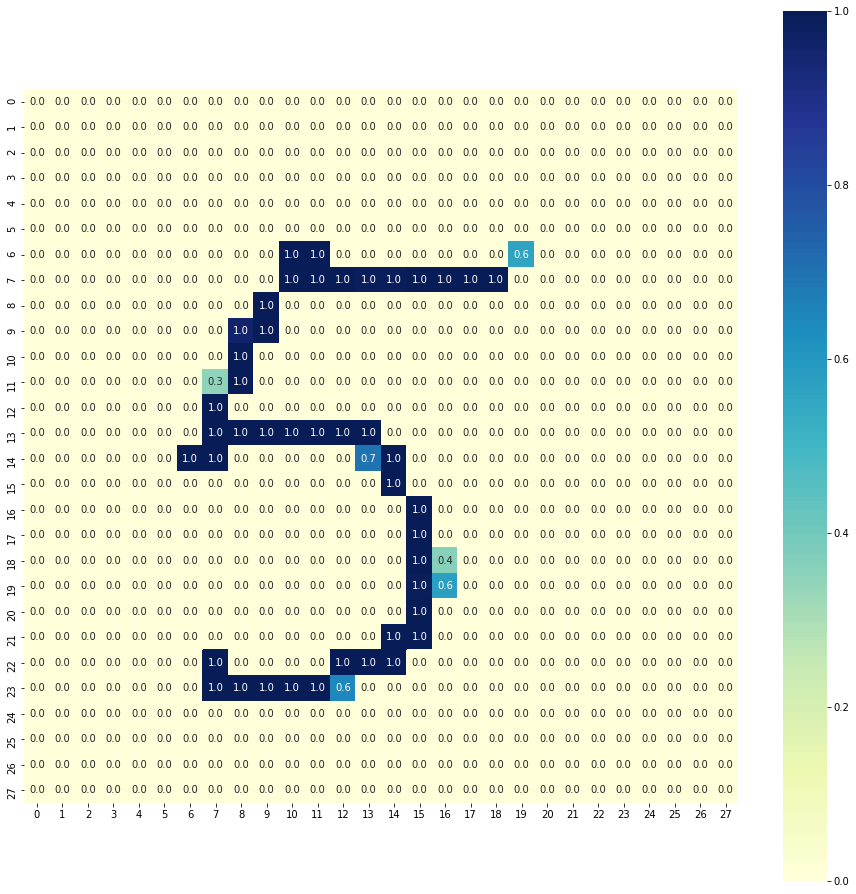

In [75]:
pic1 = Image.open('5.png')
pic1 = pic1.resize((28,28),Image.ANTIALIAS)
pic1 = pic1.convert('L')
matrix1=np.array(pic1).astype(np.float16)
matrix1=matrix1.flatten()
maxp=max(matrix1)
minp=min(matrix1)
m=float(maxp-minp)
for i in range(0,784):
  matrix1[i]=float((255-matrix1[i])/m)
  

matrix1=np.append(matrix1,1)
y_pred = np.argmax(np.dot(W, matrix1))
print(softmax(np.dot(W, matrix1)))
print("prediction is: %d"%(y_pred))
matrix1=np.delete(matrix1,-1)
matrix1=np.reshape(matrix1,(28,28))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(matrix1, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

### Image #3

Write the code to show the image #3 here.

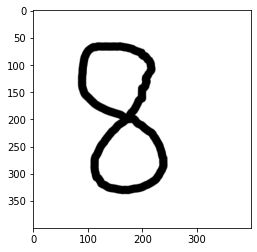

In [76]:
import matplotlib.image as mpimg
 
pic1 = mpimg.imread('8.png')
pic1.shape 
plt.imshow(pic1)  
plt.show()

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.

[2.33985477e-04 4.91526379e-07 5.81003030e-02 6.45620068e-01
 4.01394506e-04 1.90690890e-01 9.56903813e-02 4.80494272e-08
 9.25990980e-03 2.52812122e-06]
prediction is: 3


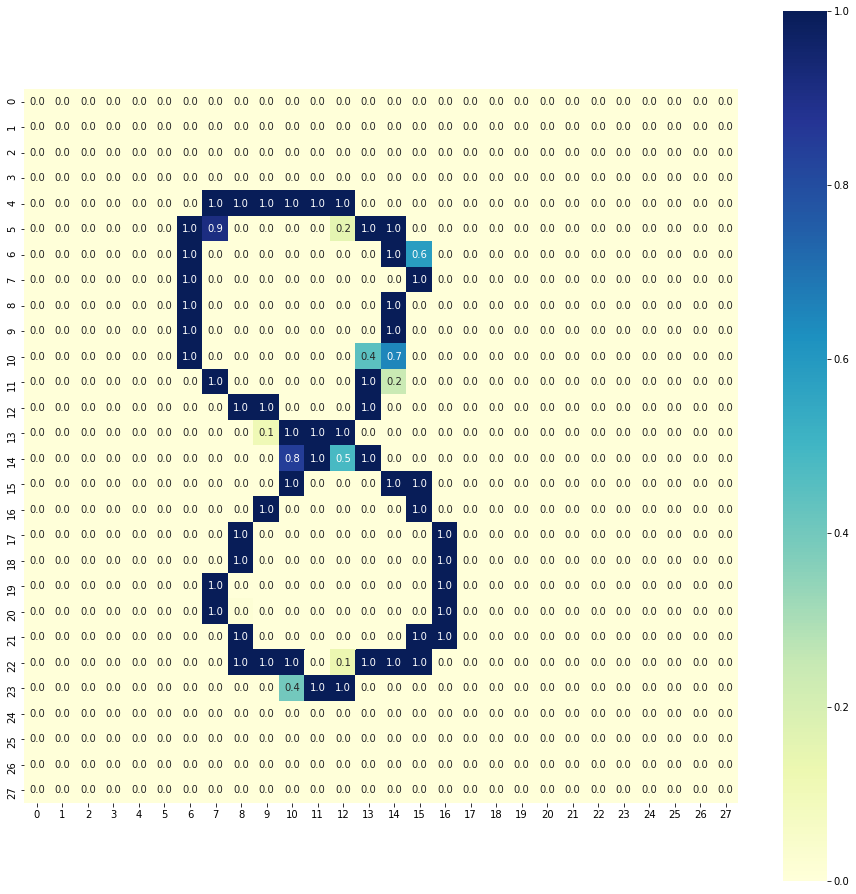

In [77]:
pic1 = Image.open('8.png')
pic1 = pic1.resize((28,28),Image.ANTIALIAS)
pic1 = pic1.convert('L')
matrix1=np.array(pic1).astype(np.float16)
matrix1=matrix1.flatten()
maxp=max(matrix1)
minp=min(matrix1)
m=float(maxp-minp)
for i in range(0,784):
  matrix1[i]=float((255-matrix1[i])/m)
  

matrix1=np.append(matrix1,1)
y_pred = np.argmax(np.dot(W, matrix1))
print(softmax(np.dot(W, matrix1)))
print("prediction is: %d"%(y_pred))
matrix1=np.delete(matrix1,-1)
matrix1=np.reshape(matrix1,(28,28))
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(matrix1, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()